<div class="alert alert-success">
  Hey again! Such a great job now! I've read the whole report and ended up with no questions at all. You've done a fantastic EDA and your model performs well enough, so we can move it to production. Such a great job! My congratulations on completing the program!
</div>

<div class="alert alert-info"> The client, Interconnect, asked us to create an algorithm that will determine if the client is planning to leave or not. This is clearly a classification problem. We were provided with multiple features for each customerID splitted betyween 4 csvs.
This notebook will explore the data, and create a plan of action, a blueprint of the future algorithm...</div>


First let's import some usefull libraries:

In [529]:
import sys
assert sys.version_info >=(3,5)
import sklearn
import numpy as np
import os
import glob
import pandas as pd
import pathlib2 as pl2
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
    
from IPython.display import display


# <div class="alert alert-info"> FUNCTIONS </div>

Let's write some utility functions:

In [530]:
def plot_roc_auc(model):
    name = model.__class__.__name__
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1], pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve of {name} model : {round(roc_auc_sc, 3)*100}')
    plt.show()
    
    
def validate(model, val_data):
    y = model.predict(val_data[0])
    print('Accuracy =', accuracy_score(y, val_data[1]))
    print('ROC AUC =', roc_auc_score(y, val_data[1]))
    print('F1 =', f1_score(y, val_data[1]))
    
def tuned_model(model, new_model): 
    name = model.__class__.__name__

    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    model_random.fit(X_train, y_train)

    #Save best parameters as params
    params = model_random.best_params_

    # Create a new model, pass the best params
    tuned_model = new_model(**params)

    # Train the new model
    tuned_model.fit(X_train, y_train)

    # Evaluate the roc auc score of the new model
    roc_auc_sc = roc_auc_score( y_test, tuned_model.predict_proba(X_test)[:, 1])

    # Print the result
    print(f"ROC_AUC score of tuned {name}: {round(roc_auc_sc, 3)*100}")

    # Plot the ROC AUC curve
    plot_roc_auc(tuned_model)

def analizer(somedata, contract_dataset):
    display(somedata.head(3))
    display(somedata.info())
    if contract_dataset == True:                                           # for contract.csv file, perform the following:
        somedata[somedata["TotalCharges"].str.isspace()] = np.nan          # replace empty spaces in TotalCharges with nans
        somedata.TotalCharges = somedata.TotalCharges.astype(
            dtype = float, errors = 'raise')                               # convert str in TotalCharges to floats
        somedata.hist(bins = 50, figsize = (18,6))  # plot hist
        class_columns = somedata.columns.drop(
            ["MonthlyCharges", "TotalCharges"])                            # drop the numerical columns
        for z in somedata[class_columns]:                                  # for cathegorical columns print the following:
            print(z )
            print(somedata[z].value_counts())
            print("-------------------------")
    else:                                                                  # for all the other files, perform the following:
        for z in somedata.columns[1:]:
            print(z )
            print(somedata[z].value_counts())
            print("-------------------------")
            
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title( 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Importing The Data

In [531]:
ps = pl2.Path(r'C:\Users\vlady\Downloads\final_provider')
contract, internet, personal, phone = (pd.read_csv(p, encoding='utf8') for p in ps.glob('*.csv'))


## contract.csv

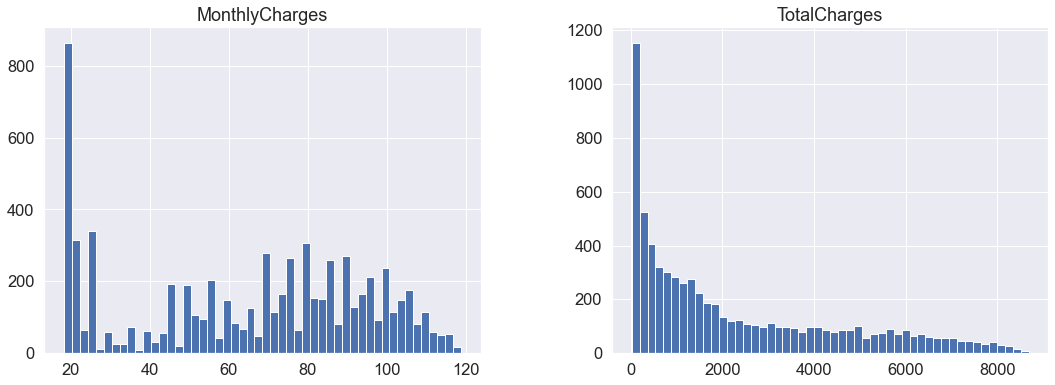

In [532]:
analizer(contract, contract_dataset = True)

In [533]:
# Are there any nans?

contract.isna().sum()

## personal.csv

In [534]:
analizer(personal, contract_dataset = False) 

## internet.csv

In [535]:
analizer(internet, contract_dataset = False) 

## phone.csv

In [536]:
analizer(phone, contract_dataset = False) 

# EDA

### Are there are duplicates in the customerID column.
Let's find these nans and print a sample

In [537]:
dictionary =  {"contract":contract, "internet":internet, "personal":personal, "phone":phone}
for key, value in dictionary.items():
        print(f"Duplicates in {key} file : {value.customerID.duplicated().sum()}")
        print(" ")
        if value.customerID.duplicated().sum() > 0:
        #    print(value[value.duplicated(['customerID'], keep=False)].sort_values(by=['customerID']))
            print(f"ATTENTION! DUPLICATED CUSTOMER_ID IDENTIFIED IN FILE {key.upper()}.CSV")
            print(" ")

ids = contract["customerID"]
contract[ids.isin(ids[ids.duplicated()])].sort_values("customerID")

A quick glance on the problematic file reveals that our duplicates are not "real" duplicates but Nans. We will probably need these indexes in our next step, therefore we will not drop them.

### Merge the files into df.

In [538]:
x = pd.merge(contract, internet, how='outer', on = 'customerID')
x = pd.merge(x, personal,how='outer', on = 'customerID') 
df =  pd.merge(x, phone,how='outer', on = 'customerID') 
df.drop(columns ="customerID", inplace = True)
df.info()

<div class="alert alert-success">
<b>Reviewer's comment</b>

Dataframes were merged correctly!

</div>

### Convert date columns' dtypes to datetime.

Working with the dates we should pay a special attention to the EndDate column. In order to work with the dates we should convert the obj to datetime dtype.In order to do this we must asign a date to the "No" instances in the column. The natural
tendency would be to asign these values with the date of the data collection (02.01.2020) yet the problem is that 
by doing so we might mix these dates with the actual 02.01.2020 EndDates. Therefore, first we will asign the "No" with 03.01, to check that there are no 02.01.2020 EndDates... 

The EndDate_copy column will later become our binary target column, so we are good with object dtype for now.

In [539]:
df['EndDate_copy'] = df['EndDate']               # let's saver a copy of EndDate column
df['EndDate'] = df['EndDate'].replace("No", pd.to_datetime("2020-03-01")) # replace all the "No" strs with 26.02 date
df['EndDate'] = pd.to_datetime(df['EndDate'],format='%Y-%m-%d')     # convert all the EndDate column to datetime format
df['BeginDate'] = pd.to_datetime(df['BeginDate'],format='%Y-%m-%d') # convert all the BeginDate column to datetime format

In [540]:
# Let's check that the dates covertion worked:

df[["BeginDate", "EndDate", "EndDate_copy" ]].info()

Let's see the hist of the instances on the timeline:

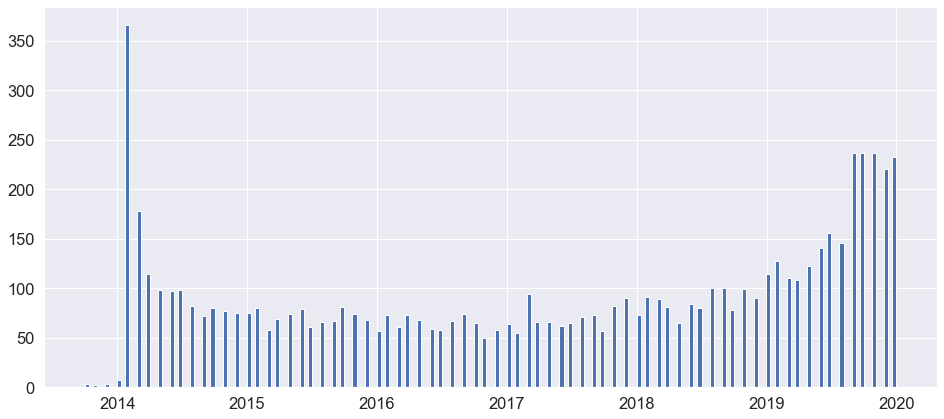

In [541]:
df['BeginDate'].hist(bins = 200, figsize = (16,7));

On the left bottom corner of the plot: we can notice there are a few rare instances in the 2013, early 2014 that have no significant volume. Let's drop these instances. 
These are probably the very first clents of the company and they will not represent the overall Churn of the dataset.
Usually the very first clients benefit from very low prices and other bonuses that might influence their decision to stay/leave the company. 

# DATES FILTERING

In [542]:
df = df.loc[(df['BeginDate'] >= '2014-02-01')] # Let's drop early instances from our df
 

In [543]:
def datechecker(data):
    earliestBD = data['BeginDate'].min()
    latestBD = data['BeginDate'].max()
    earliestED = data['EndDate'].min()
    latestED = data['EndDate'].max()    
    print(f" Earliest BeginDate = {earliestBD}, \n Latest BeginDate = {latestBD}, \n Earliest EndDate = {earliestED}, \n Latest EndDate = {latestED}")

datechecker(df)

Let's inspect the columns with an historgram:

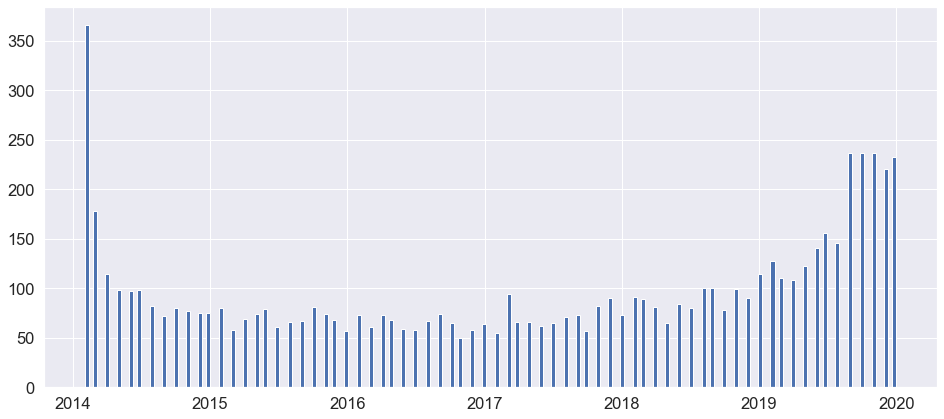

In [544]:

df["BeginDate"].hist(bins = 200, figsize = (16,7)); 

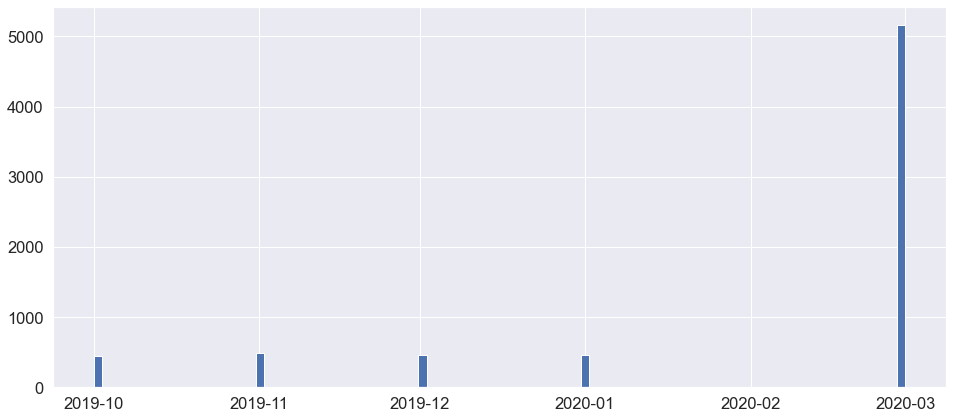

In [545]:
df["EndDate"].hist(bins = 100, figsize = (16,7)); 

In [546]:
df["EndDate"].value_counts()


By ploting we have learned that there are only 4 EndDates in our dataset. The last column (2020-02) are the original "No" instances but we have moved the dates one month further. We did this, temporarily, to check if there are no EndDates at 2020.02. 
As we can see there are no people that ended their contract on the day of the data collection (02.2020), therefore we can asign the instances that had their contracts rolling with the date of the original data collection (02.2020):


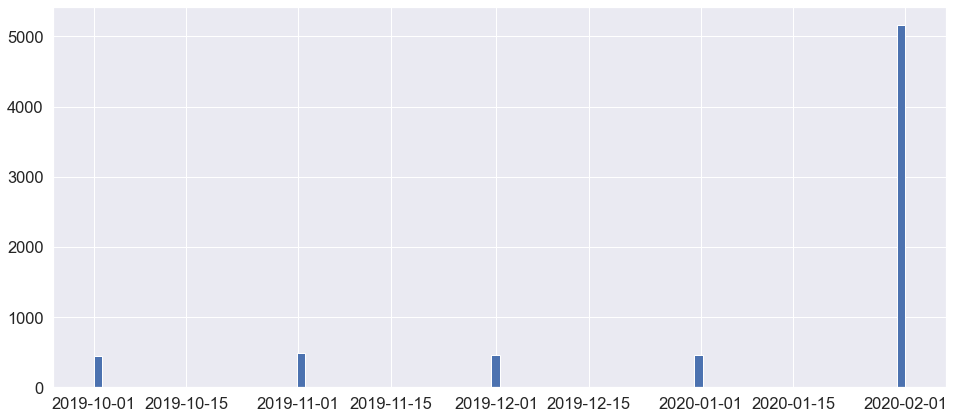

In [547]:
df['EndDate'] = df['EndDate'].replace("2020-03-01 00:00:00", "2020-02-01 00:00:00")
df["EndDate"].hist(bins = 100, figsize = (16,7)); 

In [548]:
# Let's create a column for the months of the BeginDate
df["Months"] = df['BeginDate'].dt.month

# And the year of the BeginDate
df["Years"] = df["BeginDate"].dt.year

In [549]:
# And convert these dt types to integers:

df["Months"] = df["Months"].astype(int)
df["Years"] = df["Years"].astype(int)

### Task 5: OneHot encode the categorical columns.

In order to one hot encode the categorical columns we must first:
Replace dates in EndDate_copy with 0, "No" with 1,  and rename this column to "Churn". This will become our target column.

In [550]:

df.loc[df['EndDate_copy'] == "No", 'EndDate_copy'] = 1
df.loc[df['EndDate_copy'] != 1, 'EndDate_copy'] = 0
df.rename(columns={'EndDate_copy': 'Churn'}, inplace=True)

df.head(3)

In [551]:
# Now let's one hot encode the categoricals:

df = pd.get_dummies(df, drop_first=True)
df.head(3)

In [552]:
df.isna().sum()

In [553]:
# Let's add the OHE months and years columns to the df

ohe_months = pd.get_dummies(df["Months"], drop_first=True)
ohe_years = pd.get_dummies(df["Years"], drop_first=True)

df = pd.merge(df, ohe_months, how='outer', left_index=True, right_index=True)

df = pd.merge(df, ohe_years, how='outer',left_index=True, right_index=True)

df.drop(columns = ["Months", "Years"], inplace = True)

### Step 10. Create "Tenure" column (the level of "loyalty" of the customer, expressed in months)

In [554]:
# import warnings
# warnings.filterwarnings('ignore')

# df["Tenure"] = df["EndDate"].dt.to_period('M').astype(int) - df["BeginDate"].dt.to_period('M').astype(int)
# df["Tenure"].hist(bins = 100, figsize  = (14,6));


<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, that's a good feature!

</div>

### Step 11 Discretize the "Tenure" column.

In [555]:
# Let's see the mins and maxs of the Tenurte column:
# df.Tenure.min(), df.Tenure.max()

In [556]:
# df['Tenure_cohorts'] = pd.cut(df['Tenure'], 
#                             bins=[0, 12, 24, 36, 48, 60, df['Tenure'].max()], 
#                             labels=['0–12 Month', '12–24 Month', '24–36 Months', "36-48 Months", "48–60 Month", "> 60 Month",])

In [557]:
# df['Tenure_cohorts'].value_counts()


In [558]:
# tenure_cohorts = pd.get_dummies(df['Tenure_cohorts'])
# tenure_cohorts

In [559]:
# df = pd.merge(df, tenure_cohorts, how='outer',left_index=True, right_index=True)
# df.head(5)

In [560]:
# df.drop(columns = ["Tenure_cohorts"], inplace =True)
# #df.drop(columns = ["Tenure"], inplace =True)

In [561]:
df.columns

In [562]:
df['MonthlyCharges'].max()

In [563]:
cohs = np.linspace(start = df['MonthlyCharges'].min(), stop = df['MonthlyCharges'].max(), num = 5)

df['Monthly_charges_cohorts'] = pd.cut(df['MonthlyCharges'], 
                             bins=cohs, 
                             labels=['1st', '2nd', '3rd', "4th"])

In [564]:
monthly_charges_cohorts = pd.get_dummies(df['Monthly_charges_cohorts'])
monthly_charges_cohorts

In [565]:
df = pd.merge(df, monthly_charges_cohorts, how='outer',left_index=True, right_index=True)
df.head(5)

In [566]:
df.drop(columns = ["MonthlyCharges", "Monthly_charges_cohorts"], inplace =True)
#df.drop(columns = ["Tenure"], inplace =True)

In [1]:
# df.drop(columns = "TotalCharges", inplace = True)


In [569]:
# We can also drop the [BeginDate", "EndDate"] columns. We don't need them anymore. 
df.drop(columns = ["BeginDate", "EndDate"], inplace = True)

# We save the SeniorCitizen column as int and then binarize it
df.SeniorCitizen = df.SeniorCitizen.astype(int)


In [571]:
df

# Split the data

In [573]:
# To avoid future error
df.columns = df.columns.astype(str)

from sklearn.model_selection import train_test_split

X = df.drop(['Churn_1'],axis=1)   # independant features
y = df['Churn_1']                 # dependant variable

# Choosing test size to split between training and testing sets:
X_combained, X_test, y_combained, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_combained, y_combained, test_size=0.20, random_state=42)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test

</div>

# <div class="alert alert-info"> Model Training </div>

In [574]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score
from catboost import CatBoostClassifier
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)

### Scale the numerical features: MonthlyCharges.

To avoid data leak we will only scale the train set. We will the scale the test with our training scaler:

In [575]:
# from sklearn.preprocessing import StandardScaler # import the Scaler from Sklearn

# scaler = StandardScaler() # asign StandardScaler class to scaler      

# # fit the scaler to the training set and transform it:
# X_train[["MonthlyCharges"]] = scaler.fit_transform(X_train[["MonthlyCharges", ]])

# # fit the scaler to the training set and transform it:
# X_val[["MonthlyCharges"]] = scaler.fit_transform(X_val[["MonthlyCharges"]])#, "TotalCharges", "Tenure"



<div class="alert alert-warning">
<b>Reviewer's comment</b>

Scaling was applied correctly for the case when we just train one model on the train set and evaluate it on the test set, but for cross-validation it's more appropriate to apply scaling in each cross-validation fold separately (e.g. using [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html))

</div>

In [576]:
# X_train.drop(columns = "TotalCharges", inplace =True)
# X_val.drop(columns = "TotalCharges", inplace =True)

In [577]:
# X_train.drop(columns = ["Months", "Years"], inplace =True)
# X_val.drop(columns =["Months", "Years"], inplace =True)

In [578]:
X_train.info()

# TESTING WITH ML MODELS

In [579]:


classifiers = [
    CatBoostClassifier(verbose = False),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

mean_ML_roc_auc = []


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    test_predictions = clf.predict(X_val)
    acc = accuracy_score(y_val, test_predictions)
    acc_roc = roc_auc_score( y_val, clf.predict_proba(X_val)[:, 1])
    mean_ML_roc_auc.append(acc_roc)
    print("Accuracy: {:.4%}".format(acc))
    print("ROC AUC : {:.4%}".format(acc_roc))


print("="*30)
print(f"Mean ROC_AUC for the tested ML model is {sum(mean_ML_roc_auc)/len(mean_ML_roc_auc)}")    


### Out of the box models provide an average ROC_AUC of 83.2% on the val data.
Let's see if we can fine tune the results of selected models. We will then choose the best performing model, retrain it on val and train set and then use the test set to estimate the final roc_auc score.

# RANDOM FOREST CLASSIFIER

Let's create a set of parameters to iterate through:

In [467]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt'] has been deprecated 
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5,6, 10,11,12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,5,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


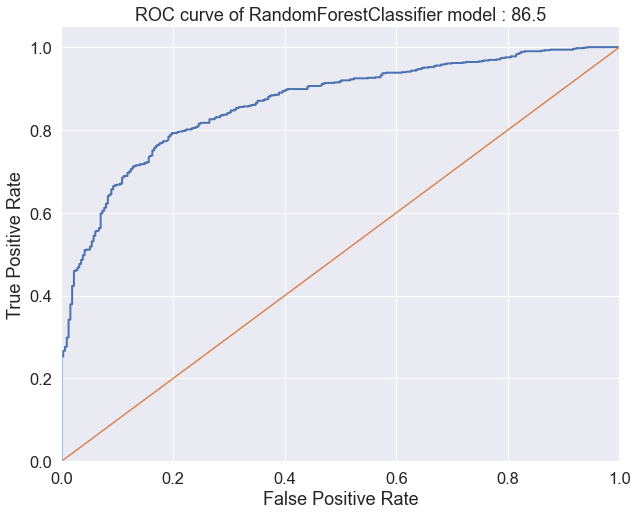

In [468]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

params = rf_random.best_params_


tuned_forest = RandomForestClassifier(**params)

tuned_forest.fit(X_train, y_train)

roc_auc_sc = roc_auc_score( y_val, tuned_forest.predict_proba(X_val)[:, 1])

print(f"ROC_AUC score of tuned forest model: {round(roc_auc_sc, 4)*100}")

plot_roc_auc(tuned_forest)


In [326]:
rf_random.best_params_

### With initial ROC_AUC of 85.1 we've improved our score by 1.5% to 86.6%

# GRADIENT BOOSTING CLASSIFIER

In [469]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 95, stop = 110, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [17,20,21,22,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [7,8,9,10,11,12]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf }
print(random_grid)

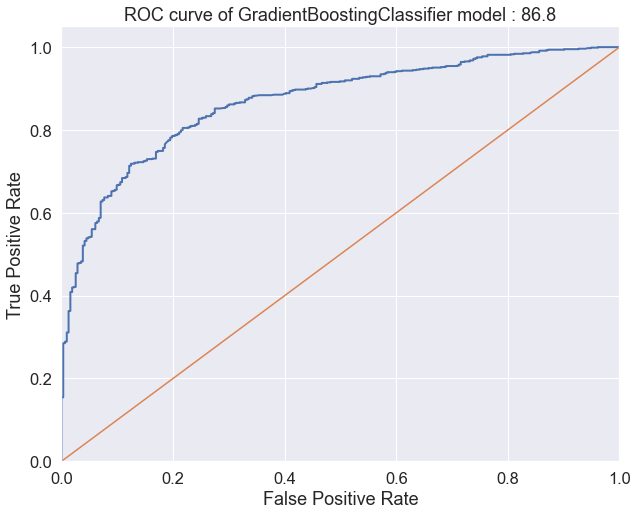

In [470]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
grad = GradientBoostingClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grad_random = RandomizedSearchCV(estimator = grad, param_distributions = random_grid, n_iter = 500, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
grad_random.fit(X_train, y_train)

#Save best parameters as params
params = grad_random.best_params_

# Create a new model, pass the best params
tuned_grad = GradientBoostingClassifier(**params)

# Train the new model
tuned_grad.fit(X_train, y_train)

# Evaluate the roc auc score of the new model
roc_auc_sc = roc_auc_score( y_val, tuned_grad.predict_proba(X_val)[:, 1])

# Print the result
print(f"ROC_AUC score of tuned grad model: {round(roc_auc_sc, 3)*100}")

# Plot the ROC AUC curve
plot_roc_auc(tuned_grad)


# CATBOOST CLASSIFIER

In [474]:
random_grid = {
        'depth': [1,2, 3, 4,],
        'l2_leaf_reg': [ 9,12,13,14,15],
       #  "n_estimators": [110, 120,130, 150,],
          "random_strength" : [2,3,4,],
          "learning_rate" : [0.01,0.02,],
}

In [476]:
# Base model to tune
catboost = CatBoostClassifier()

# Random search of parameters, using 3 fold cross validation, across 100 different combinations
catboost_random = RandomizedSearchCV(estimator = catboost, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the random search model
catboost_random.fit(X_train, y_train)

#Save best parameters as params
params = catboost_random.best_params_

# Create a new model, pass the best params
tuned_cat = CatBoostClassifier(**params)

# Train the new model
tuned_cat.fit(X_train, y_train)

# Evaluate the roc auc score of the new model
roc_auc_sc = roc_auc_score( y_val, tuned_cat.predict_proba(X_val)[:, 1])

# Print the result
print(f"ROC_AUC score of tuned grad model: {round(roc_auc_sc, 3)*100}")



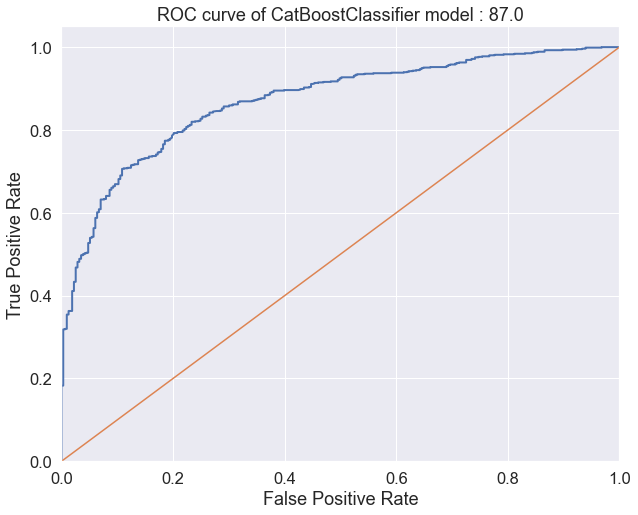

In [477]:
# Plot the ROC AUC curve
plot_roc_auc(tuned_cat)

### CatBoost Classifier achived 87% ROC_AUC score on our val dataset. 

# Testing on our best performing model:

### We decided to move forward with the Catboost classifier as our model of choise for the evaluation on the test set.

## Testing on the Catboost.

* Step 1: Retrain the model on the combined dataset (X_val +X_train)
* Step 2: Final test on the test set. 

In [580]:
X_combained

In [581]:
X_test

In [582]:

# Step 2 

best_params = catboost_random.best_params_

# Create a new model, pass the best params
best_cat = CatBoostClassifier(**best_params)

# Train the new model
best_cat.fit(X_combained, y_combained, verbose = 0)

# Evaluate the roc auc score of the new model
roc_auc_sc = roc_auc_score( y_test, best_cat.predict_proba(X_test)[:, 1])

# Print the result
print(f"ROC_AUC score of tuned grad model: {round(roc_auc_sc, 3)*100}")


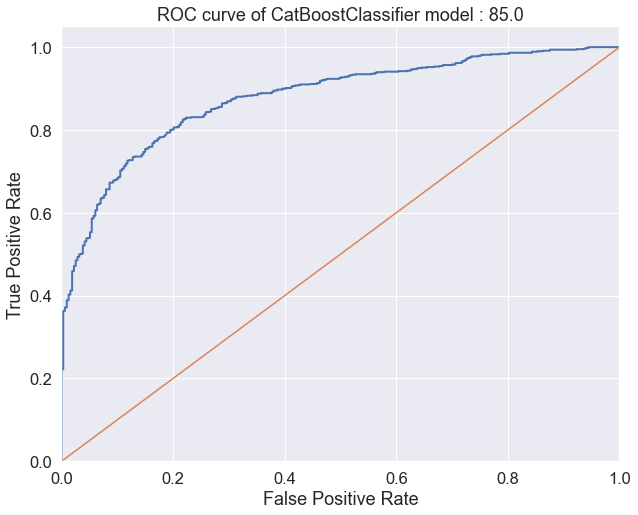

In [583]:
plot_roc_auc(best_cat)

# Feature Importance

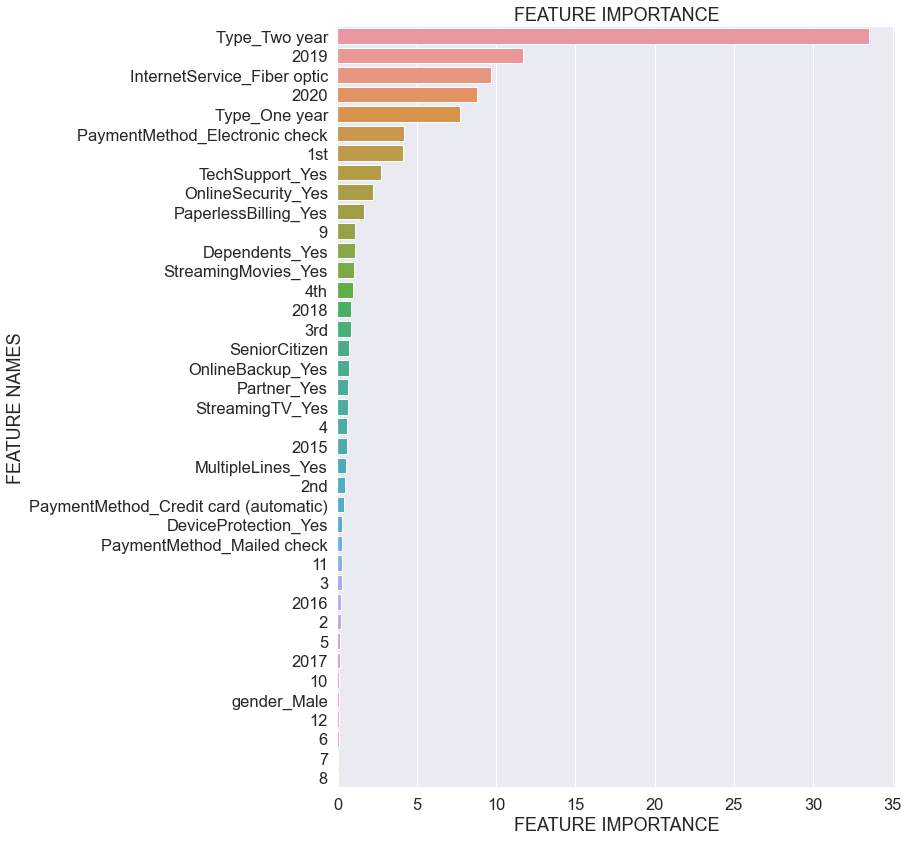

In [584]:
plot_feature_importance(best_cat.feature_importances_, X_train.columns,'CATBOOST')


<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Both problems fixed!

</div>

# REPORT 

### My initial plan included 20 steps.Marked in blue are the steps that were performed. The red color is for the steps that were skipped.

<div class="alert alert-info"> 1. Check if there are duplicates in the customerID column. </div> 
<div class="alert alert-info"> 2. Unite the files contracts.csv, personal.csv, internet.csv and phone csv on the CustomerID column. </div> 
<div class="alert alert-info"> 3. Convert BeginDate, EndDate columns' dtypes to dataframe. </div> 
<div class="alert alert-info"> 4. Check for the first and last dates. Are they make sense? Remove outliers if necessary. </div> 
<div class="alert alert-info"> 5. OneHot encode the catecorical columns. </div> 
<div class="alert alert-danger"> 6. Convert from object to float the "TotalCharges" column [This column was dropped.]</div> 
<div class="alert alert-info"> 7. Check min and max values in MonthlyCharges, TotalCharges. Are they make sense? Remove outliers if necessary.</div> 
<div class="alert alert-info"> 8. Fill or drop NA values.</div> 
<div class="alert alert-info"> 9. Drop "CustomerID" column (a unique identifier for each observation that isn’t needed for modeling.) </div> 
<div class="alert alert-info"> 10. Create "Tenure" column (the level of "loyalty" of the customer, expressed in months) [I tried several methods, and didn't used the Tenure in my final model] </div>
    
<div class="alert alert-danger"> 11. Discretize the "Tenure" column. Explanation: We split the user base into six cohorts of roughly one year (12 month) tenure increments. This should help the ML algorithm detect if a group is more/less susceptible to customer churn. [Tenure was not used]</div> 
    
<div class="alert alert-info"> 12. Create the target attribute: the "Churn" column. A binary column with 0 for customers that left the company and 1 for all the rest. </div> 
<div class="alert alert-info"> 13. Shuffle and split the data to train (80%) and test set. </div> 
<div class="alert alert-danger">14. Scale the numerical tables: MonthlyCharges, TotalCharges. [My final dataset had no numerical features. Only categorical.]</div> 
<div class="alert alert-danger">15. In case lot of observations in TotalCharges columns are bunched within a small part of the range, use a log transformation to even out the data into more of a normal distribution.[TotalCharges was dropped as it correlates heavily with Monthly Charges]</div> 
<div class="alert alert-danger">16. Is our data balanced? Do we have equal # of instances of the target labels? Fix if nessecary. [We did not performed this step. Catboost allows to asign a weight to a rare label. Although we did not this option in our final model, but we did experiment with the weights if Catboost. It did not performed better than the default hyperparams.]</div> 
<div class="alert alert-info"> 17. Build a model. Try the following classifiers 
* 17.1 DecisionTreeClassifier
* 17.2 SGDClassifier
* 17.3 RandomForestClassifier
* 17.5 XGBoost,
* 17.6 CatBoost</div> 
<div class="alert alert-info"> 18. Pick the best performing model. </div> 
<div class="alert alert-info"> 19. Using GridSearch fine tune the hyperparameters. </div> 
<div class="alert alert-info"> 20. Does the new model beats the benchmark values ("Story Points", provided by the client) </div> 


### Our initial plan changed several times. Our initial plan was to feature engeneer a Tenure feature - the time of the client in the company, measured in months.  As we tuned the hyperparams, we discovered that combining numerical features with Tenure creates a data leakage problem. Our solution, one among many possible, was to one hot encode the numerical column MonthlyCharges and to completely drop both the TotalCharges and the Tenure column. We then one hot encoded the BeginingDate to months and years. Suprisingly, it performed even better than expected. We tried several models, picking the three best performing from the list of 11 initial models. We then tuned these best performing models using GridSearch on val_set. Our final model of choice was Catboost by Yandex fine tuned and trained on both train and val sets. The roc_auc score on the test_set of our final Catboost Classifier was 85%. 